<a href="https://colab.research.google.com/github/IRPARKS/NMML/blob/main/NMMLHW12P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import numpy as np

filepath = 'Rat08-20130711_017.h5'  # data file
f = h5py.File(filepath, 'r')  # read data with h5 format
fs = f.attrs['fs'][0]  # get sampling frequency of LFP signal (Hz)
print("Sampling rate: %.1f Hz" % (fs))



Sampling rate: 1250.0 Hz


In [2]:
states = []  # two states (NREM & WAKE) to be classified
# LFP recordings are store in two h5 groups for each state
# Under each h5 group, the LFP recordings are divided into several segments with different lengths.
for name, grp in f.items():
  states.append(name)
  print("State: %s" % (name))
  print("Segment IDs:")
  print(list(grp.keys()))



State: NREM
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '7', '8', '9']
State: WAKE
Segment IDs:
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7', '8', '9']


In [3]:
# Convert the recording in to numpy arrays
# Use a dictionary to store the LFP recordings of the two states
# each containing a list of numpy arrays of all segments
lfp = {key: [] for key in states}
for key in states:
  group = f[key]  # h5 group of a state
  n = len(group)  # number of segments
  for i in range(n):
    lfp[key].append(group[str(i+1)][()].astype(float))  # convert data to numpy array and from int type to float type

# print(lfp)



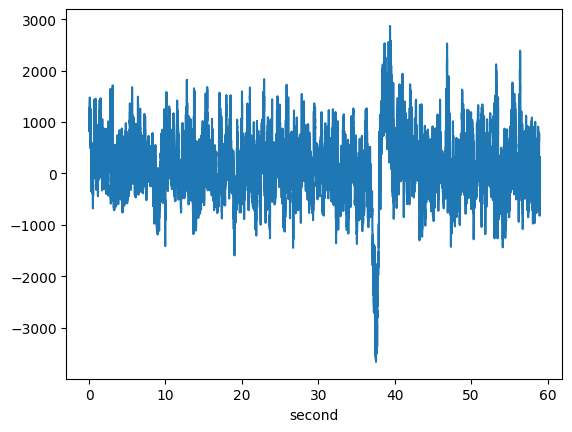

In [4]:
import matplotlib.pyplot as plt

x = lfp['NREM'][10]  # accessing the 10-th LFP segment in NREM state
t = np.arange(x.size)/fs  # time points

plt.plot(t,x)
plt.xlabel('second')
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assume `lfp` is your dictionary containing LFP recordings for different states
# `states` contains the state names (e.g., 'NREM', 'WAKE')

# Determine the maximum length of LFP segments
max_length = max(len(segment) for state in states for segment in lfp[state])

# Pad or truncate segments to a fixed length (max_length)
padded_lfp = {state: [np.pad(segment, (0, max_length - len(segment)), mode='constant') for segment in lfp[state]] for state in states}

# Concatenate all segments of LFP data into a single numpy array
data = np.concatenate([np.stack(padded_lfp[state]) for state in states])
# Create labels corresponding to each state
labels = np.array([states.index(state) for state in states for _ in range(len(padded_lfp[state]))])

# Normalize data (if needed)
data_mean = np.mean(data, axis=(0, 1), keepdims=True)
data_std = np.std(data, axis=(0, 1), keepdims=True)
data = (data - data_mean) / data_std

# Split data into train and validation sets
split_idx = int(0.75 * len(data))

train_data = TensorDataset(torch.Tensor(data[:split_idx]), torch.LongTensor(labels[:split_idx]))
valid_data = TensorDataset(torch.Tensor(data[split_idx:]), torch.LongTensor(labels[split_idx:]))

# Define batch size
batch_size = 32

# Create DataLoader for training and validation
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

# Define your CNN model
class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * (max_length // 2), num_classes)  # Adjust input size for fully connected layer

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to match expected input format (batch_size, input_channels, sequence_length)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize model
input_channels = data.shape[1]  # Number of channels in LFP data (assuming this determines input size)
num_classes = len(states)  # Number of output classes (states)
model = CNN(input_channels, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)  # No need to permute here if inputs are already in the correct format
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validate model
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {validation_loss/len(valid_loader):.4f}, "
          f"Validation Accuracy: {(100 * correct / total):.2f}%")


NameError: name 'states' is not defined